# BTC  
**Descripción:**  
Modelos de regresión para predecir el precio de cierre del Bitcoin 

**Librerias**

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#models
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRFRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


#avoids warnings
warnings.filterwarnings('ignore')

## Carga de Datos

In [2]:
#Lee o carga de los datos, pasamos las columnas de fecha tipo fecha y la colocamos en el index
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-12,42742.179688,44135.367188,42528.988281,43949.101563,43949.101563,33499938689
2022-01-13,43946.742188,44278.421875,42447.042969,42591.570313,42591.570313,47691135082
2022-01-14,42598.871094,43346.687500,41982.617188,43099.699219,43099.699219,23577403399
2022-01-15,43101.898438,43724.671875,42669.035156,43177.398438,43177.398438,18371348298
2022-01-16,43172.039063,43436.808594,42691.023438,43113.878906,43113.878906,17902097845


### EDA

In [3]:
df.shape

(791, 6)

In [4]:
#General information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 791 entries, 2022-01-12 to 2024-03-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       791 non-null    float64
 1   High       791 non-null    float64
 2   Low        791 non-null    float64
 3   Close      791 non-null    float64
 4   Adj Close  791 non-null    float64
 5   Volume     791 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.3 KB


In [5]:
# Check null values
df.isnull().sum().sum()

0

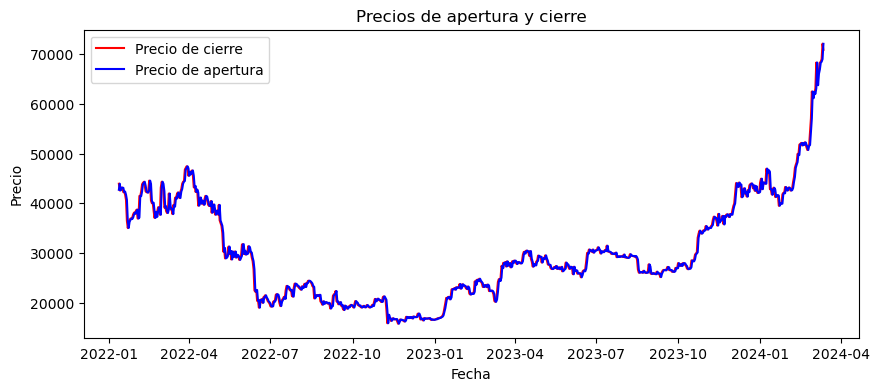

In [6]:
# Crea una figura y un eje
fig, ax = plt.subplots(figsize = [10,4])

# Traza la línea para la columna "Close"
ax.plot(df.index, df['Close'], label='Precio de cierre', color='red')

# Traza la línea para la columna "Open"
ax.plot(df.index, df['Open'], label='Precio de apertura', color='blue')

# Establece el título del gráfico
ax.set_title('Precios de apertura y cierre')

# Etiqueta los ejes
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')

# Agrega una leyenda
ax.legend()

# Muestra el gráfico
plt.show()

In [7]:
# Basic Statistysc
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,791.0,3.020476e+04,1.020682e+04,1.578230e+04,2.220659e+04,2.799407e+04,3.809010e+04,7.209898e+04
High,791.0,3.077369e+04,1.048674e+04,1.625305e+04,2.262336e+04,2.844056e+04,3.909505e+04,7.285071e+04
Low,791.0,2.965057e+04,9.993971e+03,1.559905e+04,2.157164e+04,2.737560e+04,3.752468e+04,6.921008e+04
Close,791.0,3.024087e+04,1.030008e+04,1.578728e+04,2.221328e+04,2.799433e+04,3.808975e+04,7.212391e+04
Adj Close,791.0,3.024087e+04,1.030008e+04,1.578728e+04,2.221328e+04,2.799433e+04,3.808975e+04,7.212391e+04
Volume,791.0,2.466517e+10,1.293924e+10,5.331173e+09,1.570248e+10,2.272210e+10,3.063269e+10,1.189925e+11


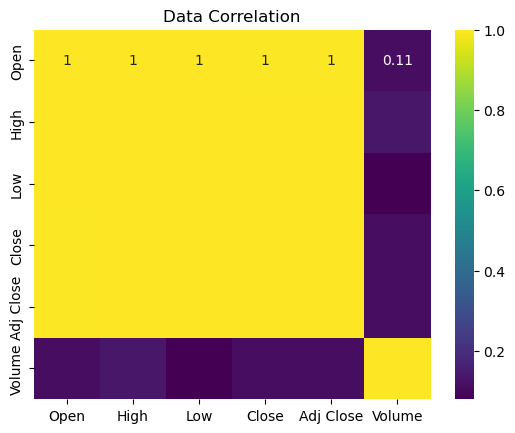

Adj Close    1.000000
High         0.998297
Low          0.997916
Open         0.995840
Volume       0.109636
Name: Close, dtype: float64


In [8]:
#data corelation
plt.title('Data Correlation')
sns.heatmap(df.corr(), annot= True, cmap='viridis')
plt.show()
print(df.corr()['Close'].sort_values(ascending= False)[1:])

#### Volume-Open Price

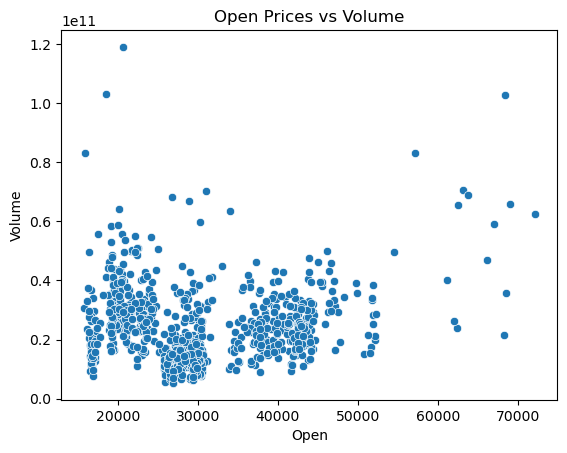

In [9]:
plt.title('Open Prices vs Volume')
sns.scatterplot(data = df, x = 'Open', y = 'Volume')
plt.show()

#### Volume-Close Price

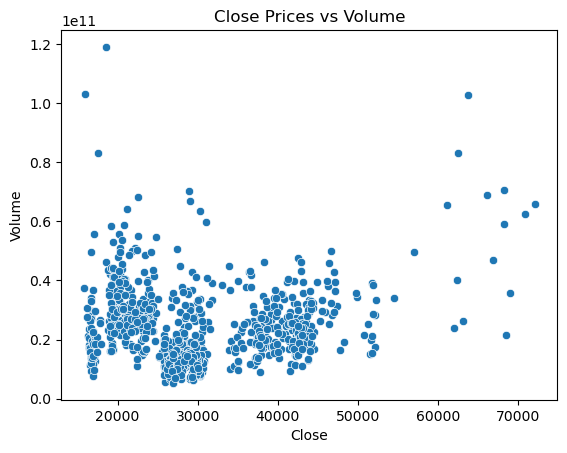

In [10]:
plt.title('Close Prices vs Volume')
sns.scatterplot(data = df, x = 'Close', y = 'Volume')
plt.show()

### Dividir los datos en:
- features  and target

In [11]:
X = df[['Open', 'Volume']]
y = df['Close']
X.shape, y.shape

((791, 2), (791,))

### Data Preprocessing

In [12]:
preprocessor = ColumnTransformer(transformers=[
    
    ('num', StandardScaler(),['Open', 'Volume'] ),
    
    
], remainder='passthrough')

## Building Model

In [36]:
#create a dict for model

model_dic = {
    'log': LinearRegression(),
    'RF': RandomForestRegressor(),
    'XGBR': XGBRFRegressor(),
    'SDG': SGDRegressor(),
    'RF': RandomForestRegressor(),
    'ADBOOST':AdaBoostRegressor(),
    'EXTATREE': ExtraTreesRegressor(),
    'GDBOSST': GradientBoostingRegressor(),
    'SVM': SVR(),
    'KNN': KNeighborsRegressor(),
    #'NB': GaussianNB(),
    'lightgbm':  LGBMRegressor(),
    'CatBoost': CatBoostRegressor(),
    
        
}

#### Function to training and valide score for all the models

In [37]:

def model_scorer(model_name, model):
  """ scores a model using R2, mean absolute error, and cross-validation (CV) R2

  Args:
      model_name: Name of the model.
      model: The model object to be scored.
      

  Returns:
      A list containing the model name, R2 score on the test set,
      mean absolute error on the test set, and the mean R2 score from cross-validation.
  """

  # Create the pipeline if not provided in arguments
  pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Assuming preprocessor is defined
    ('model', model)
  ])

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

  # Train the pipeline
  pipeline.fit(X_train, y_train)

  # Predict on the test set
  y_pred = pipeline.predict(X_test)

  # Model evaluations
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  # Perform cross-validation
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)
  cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
  cv_r2_mean = cv_results.mean()

  return [model_name, r2, mae, cv_r2_mean]

# 'model_dic'
model_output = []
for model_name, model in model_dic.items():
  output = model_scorer(model_name, model)  # Use X and y from your data
  model_output.append(output)

# Create the DataFrame from the list of output lists
score = pd.DataFrame(model_output, columns=["Model Name", "R2", "MAE", "CV R2 Mean"])


score.sort_values(by = 'R2', ascending = False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 2
[LightGBM] [Info] Start training from score 30127.769439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Model Name,R2,MAE,CV R2 Mean
0,log,0.992795,580.897489,0.990939
3,SDG,0.992749,582.620755,0.990925
6,GDBOSST,0.992119,625.783562,0.988567
5,EXTATREE,0.991179,660.165863,0.986754
1,RF,0.991169,631.041735,0.987028
10,CatBoost,0.987000,715.021994,0.987594
4,ADBOOST,0.986514,902.882785,0.982592
8,KNN,0.980883,888.360867,0.974944
9,lightgbm,0.979491,736.081836,0.974422
2,XGBR,0.976219,1165.838775,0.959141


**Comentarios**:
- El modelo con el Mejor Score es el Log-Lienar con 99.27% de R2 score y con un corss val score de 99.09%

## Predecir con el mejor modelo

In [38]:
#Create Pipeline 
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Assuming preprocessor is defined
    ('model', LinearRegression())
  ])

#training data
pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Open', 'Volume'])])),
                ('model', LinearRegression())])

In [39]:
#Sample predictions
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-08,66938.093750,70083.054688,66230.453125,68300.093750,68300.093750,59202881172
2024-03-09,68299.257813,68673.054688,68053.125000,68498.882813,68498.882813,21609650379
2024-03-10,68500.257813,70005.203125,68239.976563,69019.789063,69019.789063,35683977532
2024-03-11,69020.546875,72850.710938,67194.882813,72123.906250,72123.906250,65716656765
2024-03-12,72098.984375,72487.101563,69210.078125,70896.359375,70896.359375,62472564736


In [53]:
ex = pd.DataFrame({'Open':68371.30469, 'Volume': 49261579492},index=[0])
ex

,Open,Volume
0,68371.30469,49261579492


In [57]:
#Predictions -MAE
pipeline.predict(ex) - 580.897489

array([68008.80153439])

### Save model

In [1]:
import joblib

In [ ]:
joblib.dump(pipeline,'pipeline')

In [ ]:
#import model
model = joblib.load('pipeline')